# **Hackathon 2 Team 1 Project - Insurance Market Analysis**

# Section 3: Predictive Model

* **Objective**
    * To predict the medical insurance cost (charges) for an individual using personal and lifestyle attributes. This model enables insurers to estimate premiums more accurately, identify key cost drivers, and improve pricing transparency.

* **Input**
    * A cleaned and transformed dataset containing the following features:

        * age: Age of the individual (standardized)

        * sex: Gender (male, female) — one-hot encoded

        * smoker: Smoking status (yes, no) — one-hot encoded

        * bmi: Body Mass Index — standardized

        * children: Number of dependents — optionally standardized

        * region: Residential region (northeast, southeast, etc.) — one-hot encoded

    * The target variable charges may be log-transformed to normalize its distribution and improve model performance.

* **Output**
    * A calculator for estimated insurance cost with the predictive model.

    * If the model is trained on log-transformed charges, predictions are exponentiated to return to the original dollar scale.

---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory
We need to change the working directory from its current folder to its parent folder

* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/Users/denniskwok/Documents/data-analytics/Hackathon2Team1Project-Health-Insurance-Analysis/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory


In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/Users/denniskwok/Documents/data-analytics/Hackathon2Team1Project-Health-Insurance-Analysis'

---

# Predictive Model: Estimate Medical Costs Based on Demographic Data

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

Load the cleaned and transformed dataset

In [5]:
# Load the dataset (already clean)

df = pd.read_csv("dataset/processed/Insurance_cleaned_orig.csv")
df_encoded = pd.read_csv("dataset/processed/Insurance_cleaned_transformed.csv")
df.head()
df_encoded.head()

,ID,age,bmi,children,charges,sex_female,smoker_yes,region_southwest,region_southeast,region_northwest,log_charges
0,1,19,27.900,0,16884.92400,1,1,1,0,0,9.734176
1,2,18,33.770,1,1725.55230,0,0,0,1,0,7.453302
2,3,28,33.000,3,4449.46200,0,0,0,1,0,8.400538
3,4,33,22.705,0,21984.47061,0,0,0,0,1,9.998092
4,5,32,28.880,0,3866.85520,0,0,0,0,1,8.260197


Split features and target for train-test

In [6]:
# Split into features and target
X = df_encoded.drop(["charges", "log_charges"], axis=1)
y = df_encoded["charges"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

Train baseline Model (Linear Regression)

In [7]:
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

y_pred_lin = lin_model.predict(X_test)

print("Linear Regression Performance:")
print("MAE:", mean_absolute_error(y_test, y_pred_lin))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lin)))
print("R²:", r2_score(y_test, y_pred_lin))

Linear Regression Performance:
MAE: 4197.086197745397
RMSE: 5814.366203852963
R²: 0.7822407047860556


Train Advanced Model (Random forest)

In [8]:
rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

print("\nRandom Forest Performance:")
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("R²:", r2_score(y_test, y_pred_rf))


Random Forest Performance:
MAE: 2713.588933623694
RMSE: 4641.858415838676
R²: 0.8612107851339572


* Random Forest Performance Interpretation:
    * MAE: Average error in dollars — lower is better.
    * RMSE: Penalizes large errors — useful for understanding volatility.
    * R² Score: Proportion of variance explained — closer to 1 means better fit.

Feature Importance (Random Forest)

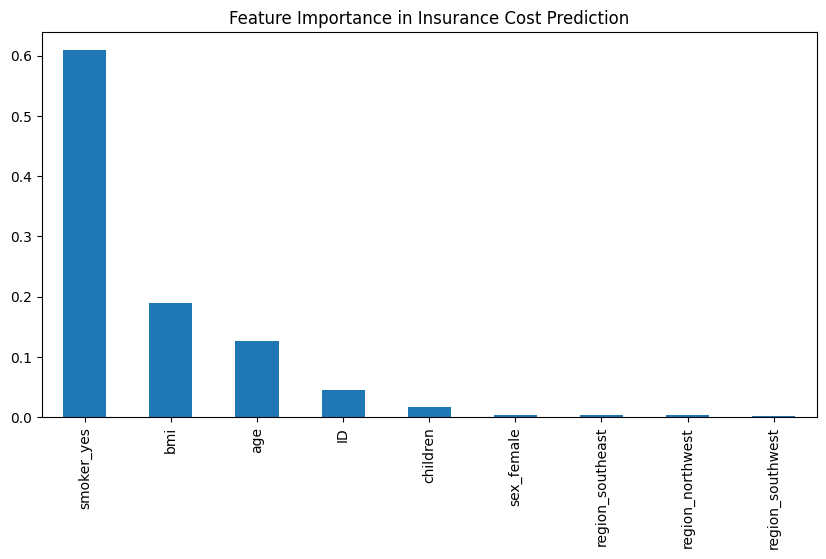

In [9]:
feat_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
feat_importances.sort_values(ascending=False).plot(kind="bar", figsize=(10,5))
plt.title("Feature Importance in Insurance Cost Prediction")
plt.show()


Chart of Predicted vs Actual visualization

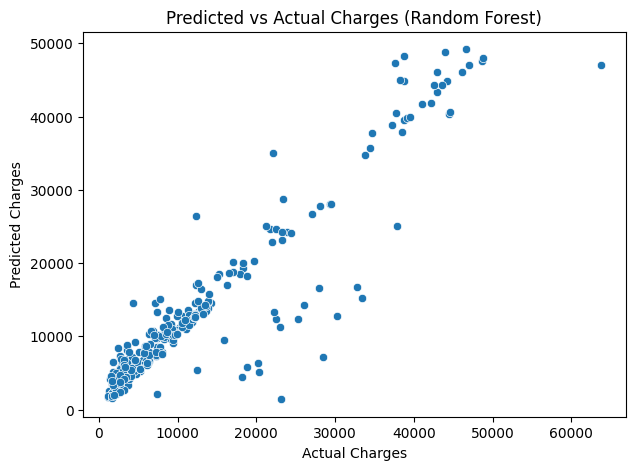

In [10]:
plt.figure(figsize=(7,5))
sns.scatterplot(x=y_test, y=y_pred_rf)
plt.xlabel("Actual Charges")
plt.ylabel("Predicted Charges")
plt.title("Predicted vs Actual Charges (Random Forest)")
plt.show()

In [11]:
def predict_insurance_cost(age, sex, bmi, children, smoker, region, model, encoder_columns):
    """
    Predict medical insurance cost for a new individual.
    
    Parameters:
        age (int): Age of the person
        sex (str): "male" or "female"
        bmi (float): Body Mass Index
        children (int): Number of children
        smoker (str): "yes" or "no"
        region (str): "northeast", "northwest", "southeast", or "southwest"
        model: trained ML model (e.g., Random Forest)
        encoder_columns: list of columns from training data (X.columns)
    
    Returns:
        float: Predicted insurance charge
    """
    
    # Build a dictionary for the new data point
    data = {
        "age": [age],
        "bmi": [bmi],
        "children": [children],
        "sex": [sex],
        "smoker": [smoker],
        "region": [region]
    }
    
    # Convert to dataframe
    new_df = pd.DataFrame(data)
    
    # One-hot encode new data
    new_encoded = pd.get_dummies(new_df, drop_first=True)
    
    # Align with training data columns (fill missing with 0)
    new_encoded = new_encoded.reindex(columns=encoder_columns, fill_value=0)
    
    # Predict using trained model
    prediction = model.predict(new_encoded)[0]
    
    return round(prediction, 2)

Predictive Model Cost Calculator Pilot Run

In [12]:
# Example: Predict for a 35-year-old male, BMI=28.5, 2 kids, smoker, living in southeast
cost = predict_insurance_cost(
    age = 35,
    sex = "male",
    bmi = 28.5,
    children = 2,
    smoker = "yes",
    region = "southeast",
    model=rf_model,
    encoder_columns=X.columns
)

print("Predicted Insurance Cost: $", cost)


Predicted Insurance Cost: $ 11176.7


Predictive Model Cost Calculator (Manual Input)

In [13]:
# Example: Predict for a 35-year-old male, BMI=28.5, 2 kids, smoker, living in southeast
cost = predict_insurance_cost(
    age = int(input("Enter an integer for age: ")),
    sex = str(input("Enter 'male' or 'female' for sex: ")),
    bmi = float(input("Enter a decimal number for bmi: ")),
    children = int(input("Enter an integer for number of children: ")),
    smoker = str(input("Enter 'yes' or 'no' for smoker status: ")),
    region = str(input("Enter 'southwest' or 'southeast' or 'northwest' or 'northeast' for region: ")),
    model=rf_model,
    encoder_columns=X.columns
)

print("Predicted Insurance Cost: $", cost)

Predicted Insurance Cost: $ 13225.26
